## Imports

In [1]:
# Set GPUs to use
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4


In [2]:
# Standard data science imports
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.io import imsave
import h5py
import rasterio

# Import class to split image into smaller tiles from 
# https://github.com/ESA-PhiLab/eo4ai/tree/master/eo4ai/utils
from splitters import * 

# Tensorflow and Keras
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/home/stewartchris/project/pythonvirtualenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stewartchris/project/pythonvirtualenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stewartchris/project/pythonvirtualenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

## Set Directories

In [3]:
# Directories
pol_path = r'/home/stewartchris/project/S1/data/S1_S0_TC_stack_mean_dB_W_UTM_AOI_clip.tif'
coh_path = r'/home/stewartchris/project/S1/data/coh_ML_TC_mean5_20191101_20191231_AOI_W_sameRes.tif'
mask_path = r'/home/stewartchris/project/S1/data/S1_S0_TC_stack_mean_dB_W_UTM_AOI_mask_clip.tif'
model_path = r'/home/stewartchris/project/S1/models/roadModelDataAugPolCoh.h5'
pred_path = r'/home/stewartchris/project/S1/data/predictionPolCoh.tif'

## Read Data and Preprocess

In [4]:
# read in data
pol_orig = imread(pol_path, key=0)
coh_orig = imread(coh_path, key=0)
mask_orig = imread(mask_path, key=0)

# merge polarimetric and coherence channels into rgb
band_orig = np.zeros((pol_orig.shape[0],pol_orig.shape[1],pol_orig.shape[2]+1))
band_orig[:,:,0:2] = pol_orig
band_orig[:,:,2] = coh_orig

In [5]:
# apply sliding window splitter, need to import splitter.py from 
# https://github.com/ESA-PhiLab/eo4ai/tree/master/eo4ai/utils

# SET WINDOW SIZE
window = 128

mask_3d = mask_orig[..., np.newaxis]
splitter = SlidingWindowSplitter(window, window) # from splitter.py
bands_patches, mask_patches, patch_ids = splitter(band_orig, mask_3d)

bpatches = np.array(bands_patches)
mpatches = np.array(mask_patches)
ipatches = np.array(patch_ids)

In [6]:
# mask out pixels where no data (0 in polarimetric and coherence)

bpatchesSum = np.sum(bpatches, axis=3)
zeroTest = np.all(bpatchesSum, axis=(1,2))
indices = np.where(zeroTest == True)
indices = indices[0]
sents = bpatches[(indices), ...].copy()
masks = mpatches[(indices), ...].copy()
ids = ipatches[(indices), ...].copy()

In [128]:
# mask out pixels where no Open Street Map

masksFlat = masks.reshape((masks.shape[0]), window*window)
index = np.where(np.sum(masksFlat, axis=1) > 0)
index = np.squeeze(np.array(index))

sents = sents[index, ...]
masks = masks[index, ...]
ids = ids[index, ...]

In [7]:
# normalise data from dB to range(0, 1)
sentsMin = np.amin(sents, axis=(0,1,2))
sentsMax = np.amax(sents, axis=(0,1,2))
sents = (sents - sentsMin) / (sentsMax - sentsMin)

In [130]:
print('The number of samples are:', sents.shape[0])

The number of samples are: 767


#### Inspect Data

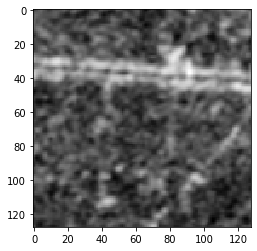

In [147]:
plt.imshow(sents[3,:,:,2], cmap='gray')

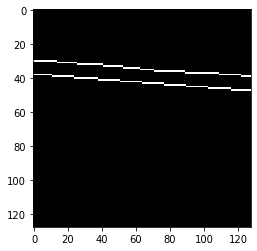

In [139]:
plt.imshow(masks[3,:,:,0], cmap='gray')

In [148]:
# split train and test data
train_size = int(sents.shape[0] * 0.8)
val_size = int(sents.shape[0] * 0.9)

sentTrain = sents[:train_size, ...]
maskTrain = masks[:train_size, ...]
idsTrain = ids[:train_size, ...]

sentVal = sents[train_size:val_size, ...]
maskVal = masks[train_size:val_size, ...]
idsVal = ids[train_size:val_size, ...]

sentTest = sents[val_size:, ...]
maskTest = masks[val_size:, ...]
idsTest = ids[val_size:, ...]

## Data Augmentation

In [149]:
data_gen_args = dict(
    rotation_range=360,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fill modes:
#'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
#'nearest': aaaaaaaa|abcd|dddddddd
#'reflect': abcddcba|abcd|dcbaabcd
#'wrap': abcdabcd|abcd|abcdabcd

### Visualise Augmented Data

In [151]:
from numpy import expand_dims

#### View original image and mask

In [152]:
index_to_view = 3

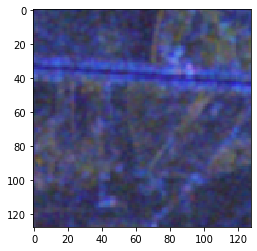

In [155]:
plt.imshow(np.squeeze(sentTrain[index_to_view]))

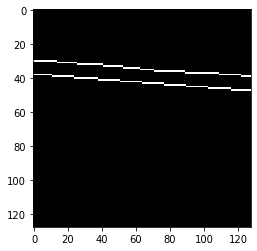

In [154]:
plt.imshow(np.squeeze(maskTrain[index_to_view]), cmap='gray')

#### View augmented images, applied to original

In [156]:
Ss = expand_dims(sentTrain[index_to_view],0)
Ms = expand_dims(maskTrain[index_to_view],0)

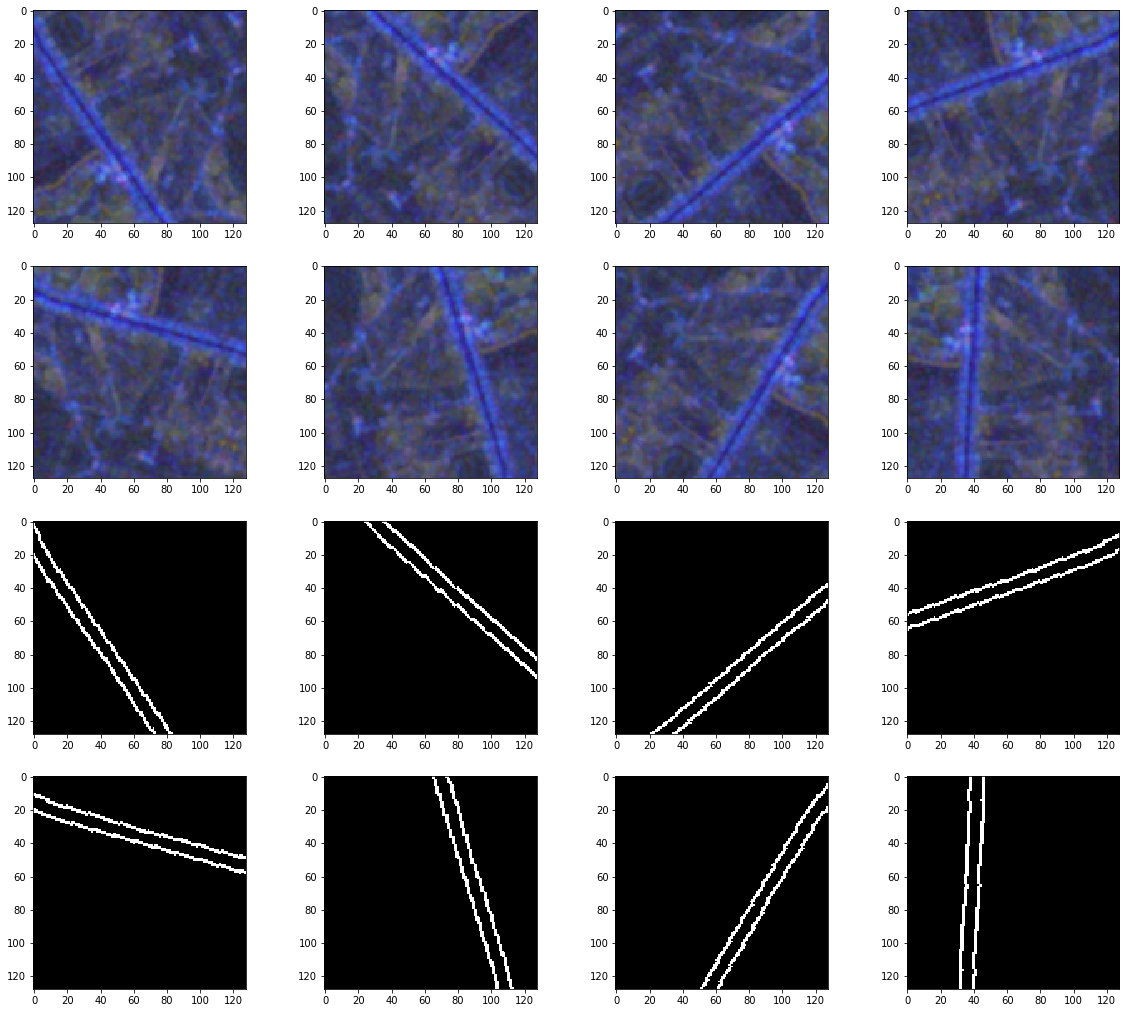

In [157]:
datagen = ImageDataGenerator(rotation_range=360, horizontal_flip=True, vertical_flip=True, fill_mode='reflect')
Sa = datagen.flow(Ss, batch_size=1, seed=1)
Ma = datagen.flow(Ms, batch_size=1, seed=1)

plt.figure(figsize=(20, 18))
for i in range(8):
    plt.subplot(4,4,1 + i)
    Sa_batch = Sa.next()
    plt.imshow(np.squeeze(Sa_batch), cmap='gray')
    plt.subplot(4,4,1 + i+8)
    Ma_batch = Ma.next()
    Ma_batch[Ma_batch > 0] = 1
    Ma_batch = Ma_batch.astype(bool)
    plt.imshow(np.squeeze(Ma_batch), cmap='gray')

## Define Hyperparameters and Data Generators

In [161]:
# Hyperparameters
EPOCHS = 100
STEPS_PER_EPOCH = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 64

In [162]:
def trainGenerator(batch_size, train_data, mask_data, aug_dict, seed):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow(train_data, batch_size = batch_size, seed = seed)
    mask_generator = mask_datagen.flow(mask_data, batch_size = batch_size, seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mas) in train_generator:
        mas[mas > 0] = 1
        mas = mas.astype(bool)
        yield (img,mas)

In [163]:
trainGene = trainGenerator(BATCH_SIZE, sentTrain, maskTrain, data_gen_args, 1)

In [164]:
def valGenerator(batch_size, val_data, val_mask_data, seed):
    image_generator = ImageDataGenerator().flow(val_data, batch_size = batch_size, seed = seed)
    mask_generator = ImageDataGenerator().flow(val_mask_data, batch_size = batch_size, seed = seed)
    val_generator = zip(image_generator, mask_generator)
    for (img,mas) in val_generator:
        mas[mas > 0] = 1
        mas = mas.astype(bool)
        yield (img,mas)

In [165]:
valGene = valGenerator(1, sentVal, maskVal, 1)

## Define U-Net Deep Learning Model for Image Segmentation

In [166]:
# define accuracy metric
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from tensorflow.keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

In [167]:
# define loss function
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [168]:
# define U-Net model
inputs = Input((window, window, 3))

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

W0218 16:08:12.565189 140716447069696 deprecation.py:506] From /home/stewartchris/project/pythonvirtualenv/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [169]:
# Compile the model
opt = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])

## Model Training

### With Data Augmentation

In [172]:
# Train the model with data augmentation
history = model.fit_generator(
    trainGene, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    epochs=EPOCHS,
    validation_data=valGene,
    validation_steps=sentVal.shape[0]
)

Epoch 1/100


W0218 16:09:58.784988 140716447069696 deprecation.py:323] From /home/stewartchris/project/pythonvirtualenv/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


100/100 [==============================] - 38s 379ms/step - loss: 0.9391 - iou_coef: 0.0355 - val_loss: 0.9662 - val_iou_coef: 0.0180
Epoch 2/100
100/100 [==============================] - 32s 320ms/step - loss: 0.9214 - iou_coef: 0.0486 - val_loss: 0.9802 - val_iou_coef: 0.0106
Epoch 3/100
100/100 [==============================] - 32s 321ms/step - loss: 0.9106 - iou_coef: 0.0556 - val_loss: 0.9794 - val_iou_coef: 0.0110
Epoch 4/100
100/100 [==============================] - 32s 321ms/step - loss: 0.9013 - iou_coef: 0.0619 - val_loss: 0.9504 - val_iou_coef: 0.0264
Epoch 5/100
100/100 [==============================] - 32s 321ms/step - loss: 0.8929 - iou_coef: 0.0659 - val_loss: 0.9361 - val_iou_coef: 0.0337
Epoch 6/100
100/100 [==============================] - 32s 321ms/step - loss: 0.8830 - iou_coef: 0.0701 - val_loss: 0.9388 - val_iou_coef: 0.0321
Epoch 7/100
100/100 [==============================] - 32s 322ms/step - loss: 0.8731 - iou_coef: 0.0727 - val_loss: 0.9260 - val_iou_coe

In [173]:
# Save the trained and compiled model to a file
model.save(model_path)

## Apply Model and Check Results

#### Check performance at training

In [174]:
print(history.history.keys())

dict_keys(['loss', 'iou_coef', 'val_loss', 'val_iou_coef'])


In [175]:
jac = history.history['iou_coef']
val_jac = history.history['val_iou_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

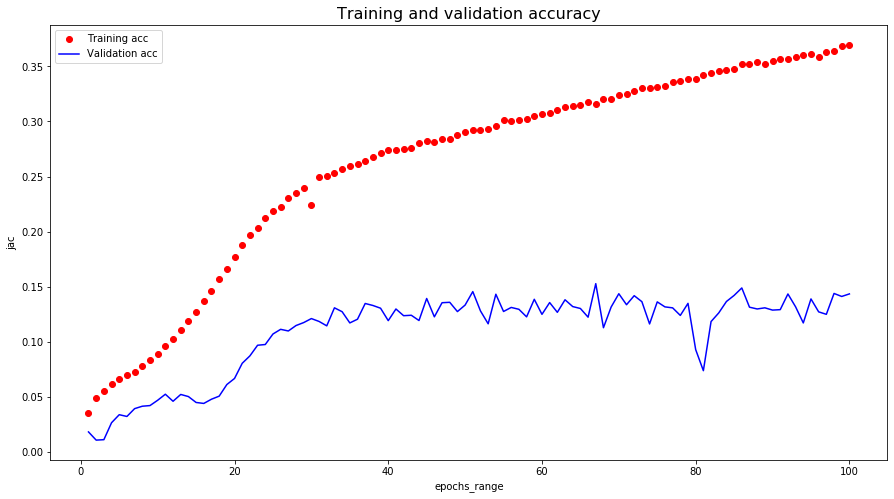

In [176]:
epochs_range = range(1, len(jac) + 1)
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(epochs_range, jac, 'bo', c='red', label='Training acc')
ax.plot(epochs_range, val_jac, 'b', c='blue', label='Validation acc')
ax.set_title('Training and validation accuracy', fontsize=16)
ax.set_xlabel('epochs_range')
ax.set_ylabel('jac')
ax.legend()

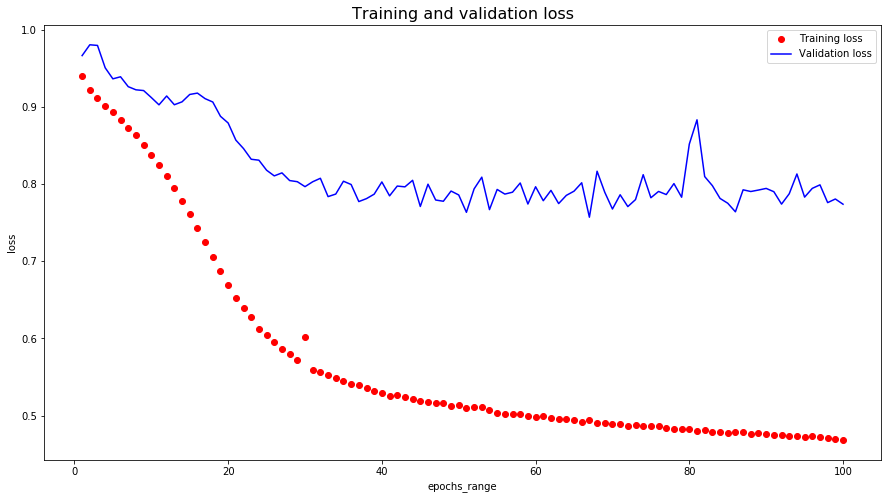

In [177]:
epochs_range = range(1, len(jac) + 1)
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(epochs_range, loss, 'bo', c='red', label='Training loss')
ax.plot(epochs_range, val_loss, 'b', c='blue', label='Validation loss')
ax.set_title('Training and validation loss', fontsize=16)
ax.set_xlabel('epochs_range')
ax.set_ylabel('loss')
ax.legend()

In [8]:
model = load_model(model_path, compile=False)

W0218 17:50:52.450381 140283742373376 deprecation.py:506] From /home/stewartchris/project/pythonvirtualenv/lib/python3.7/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0218 17:50:52.452135 140283742373376 deprecation.py:506] From /home/stewartchris/project/pythonvirtualenv/lib/python3.7/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0218 17:50:52.456191 140283742373376 deprecation.py:506] From /home/stewartchris/project/pythonvirtualenv/lib/python3.7/site-packages/tensorflo

In [9]:
# Apply model to new data
prediction = model.predict(sents, verbose=1)

4782/4782 [==============================] - 5s 1ms/sample


In [10]:
# convert deep learning output to boolean mask
prediction[prediction >= 0.5] = 1
prediction[prediction < 0.5] = 0
maskPred = prediction.astype(bool)

In [28]:
# replace original mask patches with predicted patches (i.e. to recreate 
# rectangular image, with no data padding around vector cutline)
indboo = np.isin(ipatches, ids) # boolean index
indnor = np.where(indboo == True) # normal index
mpatches_pred = mpatches.copy()
mpatches_pred[indnor,...] = prediction

In [33]:
# function to reconstruct image from patches
def reconstruct(orig2d, patches3d, window):
    n_x = (orig2d.shape[0] - window) // window + 1
    n_y = (orig2d.shape[1] - window) // window + 1
    reconstructed = np.zeros([n_x*window, n_y*window])
    for i in range(n_x):
        for j in range(n_y):
            reconstructed[i*window:(i+1)*window, j*window:(j+1)*window] = patches3d[j+(i*n_y), ...]
    recon_orig_size = np.zeros(orig2d.shape)
    recon_orig_size[:reconstructed.shape[0], :reconstructed.shape[1]] = reconstructed
    return recon_orig_size

In [34]:
# ensure prediction has correct dimension and apply function to reconstruct image from patches
pred3d = np.squeeze(mpatches_pred)
recon_orig_size = reconstruct(mask_orig, pred3d, window)

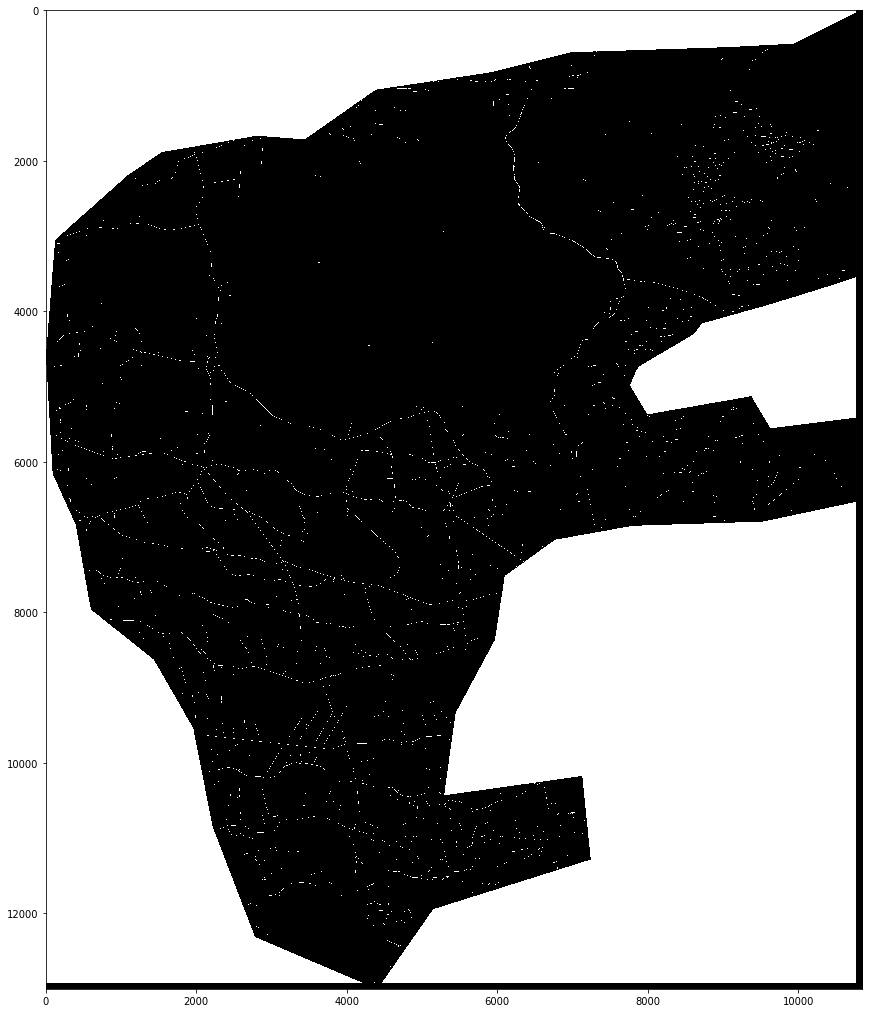

In [35]:
# check results
plt.figure(figsize=(20, 18))
plt.imshow(recon_orig_size, cmap='gray')

In [37]:
# Save output to image

with rasterio.open(mask_path) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float64, count=1)

with rasterio.open(pred_path, 'w', **profile) as dst:
    dst.write(recon_orig_size.astype(rasterio.float64), 1)